# Analysis of GTR data for subject classification

* **Goal**: To classify research entities (organisations, universities, centres) into disciplines. This is based in the idea that the portfolio of activites of an organisation in GTR reflects their disciplinary profile and specialisation.
 * *Subgoals*
   * Determine variables for classification: research subject, research topic?
   * Determine right unit of analyis: institution, location, centre, individual?
   * Determine classification formula: how do we assign units to disciplines?

* **Outputs**: Organisation metadata we can use to look at interesting questions:
 *  What are the levels of collaboration between organisations with different specialisations?
 *  What are the levels of disciplinary specialisation in different regions? 
   * Some of this could be purely be done at the area level: e.g. counts of papers by topic and region. It wouldn't require institutional classification.
   
* **Other ideas**: 
 * Use community detection in the collaboration network to detect communities.
 * Topic modelling of user profiles to define subsectors. We'll probably need to do this anyway.

In [81]:
%matplotlib inline

#Imports
import json
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns

#For network analysis and community detection
from itertools import combinations
import networkx as nx
import community #Get this package: http://perso.crans.org/aynaud/communities/

#Path for visual outputs:
out_path = "/Users/juanmateos-garcia/Desktop/Arloesiadur/data_work/outputs/"


In [2]:
#Create connection with our database
#Steps
#Load config file
with open("../scripts/config.json",'r') as f:
    config = json.load(f)

#Create connection string
conn_string = 'host={} dbname={} user={} password={}'.format(
                    config.get("host"),
                    config.get("database"),
                    config.get("user"),
                    config.get("passw"))
#Create connection
conn = psycopg2.connect(conn_string)

In [3]:
#Read the data
#We'll read it in chunks
chunk= 500

#Create sql query string
sql_query_str="""
    SELECT
        *
    FROM
        gtr.projects      
"""

#Read the data
results = pd.read_sql(sql_query_str,con=conn,chunksize=chunk)

In [4]:
#Create df from results
projects_df = pd.DataFrame()
for result in results:
     projects_df = projects_df.append(result)

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

#reindex
projects_df.reset_index(drop=True,inplace=True)

#Select relevant columns and subset
rel_vars = ['pkey','abstract_texts','grant_cats','href','identifiers',
            'lead_org_dpts','links','research_subjects','research_topics','status']
projects_rel_df = projects_df[rel_vars]

#Extract the json elements form their 1 element-dicts
projects_rel_df['research_subjects'] = projects_rel_df[
    'research_subjects'].map(lambda x: x['researchSubject'])

projects_rel_df['research_topics'] = projects_rel_df[
    'research_topics'].map(lambda x: x['researchTopic'])

## Initial EDA
We want to understand the data better:

* How many subjects and topics are there for project?
* How many projects have subjects and/or topics?
* Which types of projects have this information?

In [9]:
#How many projects have a subject?
print("{}% of projects have research subject data".format(
    np.round(100*np.sum([len(i)>0 for i in projects_rel_df['research_subjects']])/float(len(
    projects_rel_df))),2))
#And a topic?
print("{}% of projects have research topic data".format(
    np.round(100*np.sum([len(i)>0 for i in projects_rel_df['research_topics']])/float(len(
    projects_rel_df))),2))

46.0% of projects have research subject data
46.0% of projects have research topic data


In [10]:
#Which types of project have a subject?
has_subject = projects_rel_df['research_subjects'].apply(lambda x: len(x)>0)
pd.crosstab(projects_rel_df['grant_cats'],has_subject).sort(True,ascending=False)[:10]

#Understandably, innovate_uk funded activities don't have a subject. But also
    #some research fellowships and research grants don't have a subject. Does
        #this follow any pattern?

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


research_subjects,False,True
grant_cats,,
Research Grant,10307,27241
Fellowship,1588,2999
"Business, Innovation & Skills Financed",78,0
Other Grant,204,0
Training Grant,6276,0
Third Party Grant,9,0
Studentship,874,0
Smart - Proof of Market,609,0
Smart - Proof of Concept,800,0


In [11]:
#Focus analysis on research grant and fellowship projects
#Subset
projects_academic_df = projects_rel_df[[i in ['Research Grant','Fellowship'] for
                                                 i in projects_rel_df.grant_cats]]
        
#Status of a project doesn't seem to explain missing subject.
pd.crosstab(projects_academic_df['status'],has_subject)

#What about department?
inst_subject_ctab = pd.crosstab(
    projects_academic_df['lead_org_dpts'],has_subject)
inst_subject_ctab['non_subject_perc']=inst_subject_ctab[False]/inst_subject_ctab.sum(axis=1)

#Seem to be primarily biological sciences/medicine departments
inst_subject_ctab.sort(False,ascending=False)[:10]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


research_subjects,False,True,non_subject_perc
lead_org_dpts,,,
Life Sciences,380,249,0.604134
Unlisted,342,168,0.670588
Chemistry,226,1195,0.159043
UNLISTED,220,22,0.909091
Biological Sciences,213,195,0.522059
Dept of Medicine,209,15,0.933036
School of Life Sciences,208,149,0.582633
Biochemistry,196,71,0.734082
Sch of Biological Sciences,181,176,0.507003


In [12]:
#How many unique lead departments are there?
print("{} unique strings for lead organisation departments".
      format(projects_academic_df['lead_org_dpts'].nunique()))
projects_academic_df['lead_org_dpts'].value_counts()[1:10]

2246 unique strings for lead organisation departments


Physics                  1269
Physics and Astronomy     760
Computer Science          641
Life Sciences             629
Unlisted                  510
Earth Sciences            457
Geography                 449
Psychology                417
Biological Sciences       408
Name: lead_org_dpts, dtype: int64

In [13]:
#Only consider projects with subject data (drop nas and )
projects_w_subject_df = projects_academic_df[projects_academic_df.research_subjects.notnull()]
projects_w_subject_df = projects_academic_df[[len(i)>0 for i in
                                             projects_academic_df.research_topics]]

#Extract research subjects and research topics.
projects_w_subject_df['subject_list'] = [[i['text'] for i in sublist] for sublist in 
                                       projects_w_subject_df['research_subjects']]
projects_w_subject_df['topic_list'] = [[i['text'] for i in sublist] for sublist in 
                                       projects_w_subject_df['research_topics']]

projects_w_subject_df.head()

,pkey,abstract_texts,grant_cats,href,identifiers,lead_org_dpts,links,research_subjects,research_topics,status,subject_list,topic_list
0,32138,"This project is principally in combinatorics, ...",Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/A06A...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Pure Mathematics,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Mathematical sciences', u'percent...","[{u'text': u'Logic & Combinatorics', u'percent...",Closed,[Mathematical sciences],[Logic & Combinatorics]
1,32139,The aim of the project is two fold to develop ...,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/A146...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Computer Science,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Info. & commun. Technol.', u'perc...","[{u'text': u'Networks & Distributed Systems', ...",Closed,[Info. & commun. Technol.],"[Networks & Distributed Systems, Mobile Comput..."
2,32140,This project builds upon the successful UK bas...,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/A1C2...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Electronic and Electrical Engineering,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Electrical Engineering', u'percen...","[{u'text': u'Electric Motor & Drive Systems', ...",Closed,[Electrical Engineering],"[Electric Motor & Drive Systems, Power Electro..."
4,32142,"Glasgow is widely recognised, alongside London...",Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/E208...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",School of Fine Art,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Visual arts', u'percentage': 0, u...","[{u'text': u'Fine Art HTP', u'percentage': 0, ...",Closed,[Visual arts],[Fine Art HTP]
5,32143,<p>Julien Grenet's programme of research is fo...,Fellowship,http://gtr.rcuk.ac.uk:80/gtr/api/projects/E221...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Centre for Economic Performance,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Economics', u'percentage': 0, u'i...","[{u'text': u'Economics', u'percentage': 0, u'i...",Closed,[Economics],[Economics]


In [14]:
project_all_subjects = pd.Series([i for sublist in projects_w_subject_df['subject_list'] for
                       i in sublist])
projects_all_topics = pd.Series([i for sublist in projects_w_subject_df['topic_list'] for
                       i in sublist])

In [17]:
#NB "Tools, technologies and methods" seems to be a generic subject. We will drop it later.
subject_value_counts = project_all_subjects.value_counts()
print("There are {} unique subjects".format(len(subject_value_counts)))
subject_value_counts.head()

There are 82 unique subjects


Info. & commun. Technol.         3342
Tools, technologies & methods    2492
Climate & Climate Change         2089
Geosciences                      1876
Materials sciences               1789
dtype: int64

In [20]:
topic_value_counts = projects_all_topics.value_counts()
print("There are {} unique topics".format(len(topic_value_counts)))
topic_value_counts.head()

There are 607 unique topics


Climate & Climate Change      1947
Materials Characterisation    1470
Sociology                     1225
Psychology                    1076
Biogeochemical Cycles          962
dtype: int64

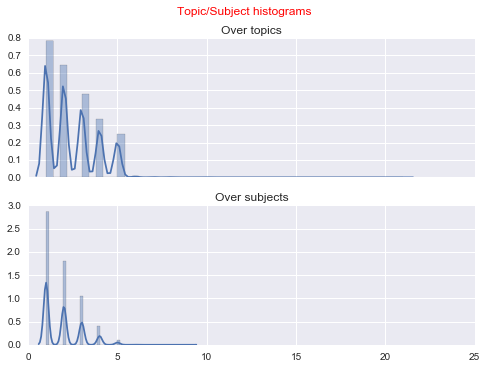

In [21]:
#Can we use co-occurrence of topics to create a taxonomy of topics and of subjects? 
#How often does it happen?
subject_n = pd.Series([len(i) for i in projects_w_subject_df['subject_list']])
topic_n = pd.Series([len(i) for i in projects_w_subject_df['topic_list']])

f, (ax1, ax2) = plt.subplots(2,sharex=True)
my_plot = sns.distplot(topic_n,ax=ax1)
my_plot.set_title("Over topics")
my_plot2 = sns.distplot(subject_n,ax=ax2)
my_plot2.set_title("Over subjects")
f.suptitle("Topic/Subject histograms",size=12,color='red')


## Community detection

* We create a network based on subject co-occurrences
* Perform community detection on the set of topics for each project in order to identify a smaller set.
* We can attach these to organisations and regions.

In [22]:
def extract_network_from_corpus(label_corpus,stop_words=None):
    """
    Extracts a network object from a corpus of documents with co-ocurring labels. 
    In the network, the labels are nodes and co-occurrences between them are edges. Weight is number of co-occurrences.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence.
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object that we can do things with (such as community detection)
    
    """
    #Container for pairs of labels
    label_pairs_container =[]
    
    #For each pair
    for i in label_corpus:
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(i,2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights
    label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']).size()).reset_index().sort(columns=0,ascending=False)
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)
    

In [23]:
#Extract communities (discipline aggregates)
subject_communities = community.best_partition(extract_network_from_corpus(projects_w_subject_df.subject_list,
                                              stop_words="Tools, technologies & methods"))
topic_communities = community.best_partition(extract_network_from_corpus(projects_w_subject_df.topic_list))


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [24]:
#The community objects are dicts where keys are subjects or topics, and values their communities
#Use this group dict to relabel variables
grouped_topics_dict = {0:"Social Sciences",
                      1:"Environmental Sciences",
                      2:"Life Sciences",
                      3:"Arts and Humanities",
                      4:"Physics",
                      5:"Mathematics and Computing",
                      6:"Engineering and Technology"}

In [26]:
#Lookup disciplines
#We use topics
projects_w_subject_df['aggregated_topics'] = projects_w_subject_df.topic_list.map(
    lambda x: [grouped_topics_dict[topic_communities[i]] for i in x])

#If there are more than 2 disciplines, we call the project Mixed (a.k.a. multi/interdisciplinary)
projects_w_subject_df['topic_classified'] = projects_w_subject_df['aggregated_topics'].map(
    lambda x: list(set(x))[0] if len(set(x))==1 else "Mixed")

#Check outputs
projects_w_subject_df.ix[1:10,['pkey','topic_list','aggregated_topics','topic_classified']]

,pkey,topic_list,aggregated_topics,topic_classified
1,32139,"[Networks & Distributed Systems, Mobile Comput...","[Mathematics and Computing, Mathematics and Co...",Mathematics and Computing
2,32140,"[Electric Motor & Drive Systems, Power Electro...","[Engineering and Technology, Engineering and T...",Engineering and Technology
4,32142,[Fine Art HTP],[Arts and Humanities],Arts and Humanities
5,32143,[Economics],[Social Sciences],Social Sciences
9,32147,"[Art History, Heritage Management, Cultural Hi...","[Arts and Humanities, Arts and Humanities, Art...",Arts and Humanities
10,32148,"[Multiprotein complexes, Structural Biology, B...","[Life Sciences, Life Sciences, Life Sciences, ...",Life Sciences


In [67]:
#Join this with the project df
project_labelled_df = projects_df.merge(projects_w_subject_df[['pkey','topic_list','aggregated_topics','topic_classified']],
                                         on="pkey",how='left')
project_labelled_df.head()

,pkey,abstract_texts,created,grant_cats,href,health_categories,id,identifiers,lead_org_dpts,links,potential_impacts,research_activities,research_subjects,research_topics,status,titles,tech_abstracts,topic_list,aggregated_topics,topic_classified
0,32138,"This project is principally in combinatorics, ...",2016-03-31 19:16:25,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/A06A...,{u'healthCategory': []},A06A7734-BD1D-40BB-B558-340085909449,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Pure Mathematics,"{u'link': [{u'otherAttributes': {}, u'href': u...",None,{u'researchActivity': []},{u'researchSubject': [{u'text': u'Mathematical...,{u'researchTopic': [{u'text': u'Logic & Combin...,Closed,"Homogeneous structures, bipartite graphs, and ...",None,[Logic & Combinatorics],[Mathematics and Computing],Mathematics and Computing
1,32139,The aim of the project is two fold to develop ...,2016-03-31 19:16:25,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/A146...,{u'healthCategory': []},A146C5A3-7448-4984-8CA3-2F490EE916D6,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Computer Science,"{u'link': [{u'otherAttributes': {}, u'href': u...",None,{u'researchActivity': []},{u'researchSubject': [{u'text': u'Info. & comm...,{u'researchTopic': [{u'text': u'Networks & Dis...,Closed,ViewNet - Context enhanced networked services ...,None,"[Networks & Distributed Systems, Mobile Comput...","[Mathematics and Computing, Mathematics and Co...",Mathematics and Computing
2,32140,This project builds upon the successful UK bas...,2016-03-31 19:16:25,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/A1C2...,{u'healthCategory': []},A1C27923-78B8-4D64-81A5-3308896E89EE,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Electronic and Electrical Engineering,"{u'link': [{u'otherAttributes': {}, u'href': u...",None,{u'researchActivity': []},{u'researchSubject': [{u'text': u'Electrical E...,{u'researchTopic': [{u'text': u'Electric Motor...,Closed,High Power IGBT Modules for Marine Drive Appli...,None,"[Electric Motor & Drive Systems, Power Electro...","[Engineering and Technology, Engineering and T...",Engineering and Technology
3,32141,To develop a modular range of micro-solar powe...,2016-03-31 19:16:25,Knowledge Transfer Partnership,http://gtr.rcuk.ac.uk:80/gtr/api/projects/E1D3...,{u'healthCategory': []},E1D34319-D0AD-4D08-9E27-3A3C1763EEC7,"{u'identifier': [{u'type': u'RCUK', u'value': ...",None,"{u'link': [{u'otherAttributes': {}, u'href': u...",None,{u'researchActivity': []},{u'researchSubject': []},{u'researchTopic': []},Active,University of Northumbria at Newcastle and Sol...,None,NaN,NaN,NaN
4,32142,"Glasgow is widely recognised, alongside London...",2016-03-31 19:16:25,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/E208...,{u'healthCategory': []},E2081C1B-7135-4AF8-8C58-3BA4748A3E6A,"{u'identifier': [{u'type': u'RCUK', u'value': ...",School of Fine Art,"{u'link': [{u'otherAttributes': {}, u'href': u...",The main beneficiary groups benefitting from t...,{u'researchActivity': []},{u'researchSubject': [{u'text': u'Visual arts'...,"{u'researchTopic': [{u'text': u'Fine Art HTP',...",Closed,'The Glasgow Miracle - New evidence and insight',None,[Fine Art HTP],[Arts and Humanities],Arts and Humanities


In [78]:
#Add attributes to networkx and output for plotting
topic_network = extract_network_from_corpus(projects_w_subject_df.topic_list)

#Add labels
#For each label in a node
for i in topic_network.node:
    #Add a category attribute based on the grouped_topic_dict and topic_communities lookups
    
    topic_network.node[i]["category"] = grouped_topics_dict[topic_communities[i]]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [86]:
nx.write_graphml(topic_network,out_path+"topic_network_14may2016.graphml")

## Quick network graph via gephi

### Node size
* Degree centrality (number of edges with other topics)

### Colours = subjects
* Orange = Life sciences
* Blue = Engineering + Technology
* Red = Physics
* Dark brown = Environmental sciences
* Dark green = Maths and computing
* Light green = Arts and Humanities
* Purple = Social sciences

<img src="topic_graph.png">